<a href="https://colab.research.google.com/github/hkrishna42/GPU-Learnings/blob/main/pmpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [13]:
import torch, os, math, gzip, pickle
import urllib.request
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline


In [14]:
path_img = Path('puppy.jpg')
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}
# if not path_img.exists(): urlretrieve(url,path_img, headers=headers)

try:
    req = urllib.request.Request(url, headers=headers)
    with urllib.request.urlopen(req) as response:
        with open(path_img, 'wb') as f:
            f.write(response.read())
    print(f"Image downloaded successfully to {path_img}")
except urllib.error.HTTPError as e:
    print(f"HTTP Error: {e.code} - {e.reason}")
except Exception as e:
    print(f"An error occurred: {e}")

Image downloaded successfully to puppy.jpg


In [15]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[116, 118, 116, 112],
         [119, 128, 127, 113],
         [130, 126, 121, 114]],

        [[ 82,  84,  84,  80],
         [ 85,  96,  95,  82],
         [ 98,  94,  88,  83]]], dtype=torch.uint8)

In [16]:
def show_img(x, figsize = (4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape) == 3: x = x.permute(1,2,0)
    plt.imshow(x.cpu(),**kwargs)

In [17]:
img2 = tvf.resize(img,150,antialias=True)
ch,h,w = img.shape
ch,h,w,h*w

(3, 1066, 1600, 1705600)

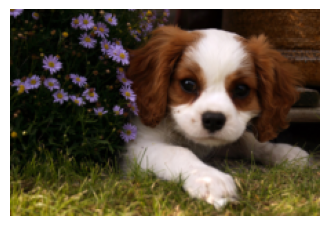

In [18]:
show_img(img2)

In [19]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [20]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.23 s, sys: 159 µs, total: 1.23 s
Wall time: 1.23 s


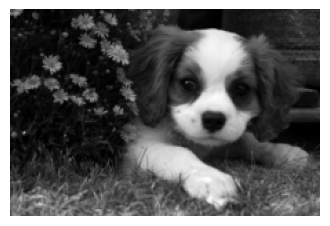

In [21]:
show_img(img_g,cmap='gray')

# **python block kernel**

In [23]:
def blk_kernel(f,blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i,j, threads,*args)

def rgb2grey_bk(blockidx,threadidx,blockdim,x,out,n):
    i = blockidx*blockdim + threadidx
    if i < n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype = x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)



# blk_kernel(f, blocks, threads, *args):
# This function simulates a GPU-like kernel launch.
# It iterates blocks number of times (representing CUDA blocks) and within each block, it iterates threads number of times (representing threads within a block).
# For each "thread," it calls the function f with blockidx, threadidx, blockdim (which is threads in this simulation), and any additional *args.
# rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
# This is the "kernel" function executed by each simulated thread.
# blockidx: The index of the current block.
# threadidx: The index of the current thread within the block.
# blockdim: The number of threads per block.
# x: The flattened input RGB image tensor.
# out: The output grayscale image tensor.
# n: The total number of pixels (height * width).
# i = blockidx * blockdim + threadidx: This calculates the global index i for the current thread, simulating how a thread's unique ID is derived in a GPU.
# if i < n:: This check ensures that threads do not access memory out of bounds if the total number of threads exceeds the actual image size.
# out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]: This performs the grayscale conversion using the standard luminosity method. It accesses the R, G, and B components for the pixel at index i from the flattened x tensor (assuming x is flattened in a way that R, G, B channels are contiguous, e.g., RRR...GGG...BBB...).
# rgb2grey_pybk(x):
# This is the main function that orchestrates the grayscale conversion.
# c,h,w = x.shape: Extracts the number of channels, height, and width from the input x (assumed to be a PyTorch tensor).
# n = h*w: Calculates the total number of pixels.
# x = x.flatten(): Flattens the input tensor x into a 1D tensor.
# res = torch.empty(n, dtype = x.dtype, device=x.device): Creates an empty PyTorch tensor res of the same data type and device as x to store the grayscale output.
# threads = 256: Sets the number of threads per block for the simulation.
# blocks = int(math.ceil(h*w/threads)): Calculates the required number of blocks to cover all pixels. math.ceil ensures that enough blocks are launched even if the total pixels are not a perfect multiple of threads.
# blk_kernel(rgb2grey_bk, blocks, threads, x, res, n): Calls the simulated kernel launcher, passing the rgb2grey_bk function, the calculated blocks and threads, and the necessary arguments for the kernel.
# return res.view(h,w): Reshapes the 1D grayscale result res back into a 2D image of height x width.

In [24]:
%%time
img_g = rgb2grey_pybk(img2)


CPU times: user 1.55 s, sys: 4.78 ms, total: 1.56 s
Wall time: 1.59 s


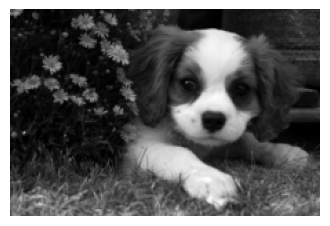

In [25]:
show_img(img_g, cmap='gray')

# **cuda setup**

In [45]:
os.environ['CUDA_LAUNCH_BLOCKING']='1' #used for dev stop when an error occurs

In [46]:
%pip install -q wurlitzer ninja

In [47]:
%reload_ext wurlitzer

In [48]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [49]:
#torch extension is to access tensors
#check contigous memory
#check
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cude/CUDAException.h>
#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHEK_CONTIGIOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contagiuous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b){return (a+b-1)/b;}
'''

In [50]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n){
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if(i<n) out[i] = 0.02989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {  // Function definition: takes a torch::Tensor as input and returns a torch::Tensor
    CHECK_INPUT(input);                                // Macro to validate the input tensor (e.g., checks if it's on CUDA, contiguous, correct data type)
    int h = input.size(1);                             // Get the height of the input tensor (assuming input is [batch_size, height, width, channels] or similar)
    int w = input.size(2);                             // Get the width of the input tensor
    printf("h*w: %d*%d\n", h, w);                      // Print the height and width for debugging purposes
    auto output = torch::empty({h, w}, input.options()); // Create an empty output tensor with the same height and width as input, and inherit options (e.g., device, data type)
    int threads = 256;                                   // Define the number of threads per CUDA block for kernel launch
                                                         // Launch the CUDA kernel 'rgb_to_grayscale_kernel'
                                                         // <<<cdiv(w*h, threads), threads>>> specifies the grid and block dimensions:
                                                        // cdiv(w*h, threads) calculates the number of blocks needed (ceiling division of total elements by threads per block)
                                                        // threads specifies the number of threads per block

    rgb_to_grayscale_kernel<<<cdiv(w * h, threads), threads>>>(
        input.data_ptr<unsigned char>(),                    // Pass a pointer to the raw data of the input tensor (assuming unsigned char for pixel data)
        output.data_ptr<unsigned char>(),                  // Pass a pointer to the raw data of the output tensor
        w * h);                                           // Pass the total number of elements (pixels) to process
    C10_CUDA_KERNEL_LAUNCH_CHECK();                      // Macro to check for any errors during the CUDA kernel launch
    return output;                                       // Return the resulting grayscale output tensor
}
'''

In [51]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [52]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [53]:

print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


In [54]:
!rm -rf ~/.cache/torch_extensions/

In [62]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

ImportError: /root/.cache/torch_extensions/py312_cu126/inline_ext/inline_ext.so: cannot open shared object file: No such file or directory

In [ ]:
!nvcc --version
!g++ --version
!python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

12.4


In [63]:
# Create a separate CUDA file with the kernel code
cuda_code = """
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    // Input is expected to be HWC (Height, Width, Channels) or CHW (Channels, Height, Width)
    // Assuming CHW based on previous usage (img.shape was [3, 1066, 1600])
    TORCH_CHECK(input.dim() == 3, "Input tensor must have 3 dimensions (C, H, W)");
    TORCH_CHECK(input.size(0) == 3, "Input tensor must have 3 channels (RGB)");
    TORCH_CHECK(input.is_contiguous(), "Input tensor must be contiguous");
    TORCH_CHECK(input.is_cuda(), "Input tensor must be a CUDA tensor");


    int h = input.size(1);
    int w = input.size(2);
    int n = h * w;

    auto output = torch::empty({h, w}, input.options());

    int threads = 256;
    int blocks = (n + threads - 1) / threads;

    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(),
        output.data_ptr<unsigned char>(),
        n
    );

    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
"""

with open("rgb_to_grayscale.cu", "w") as f:
    f.write(cuda_code)

print("CUDA code saved to rgb_to_grayscale.cu")

CUDA code saved to rgb_to_grayscale.cu


In [66]:
from torch.utils.cpp_extension import load

# Create a C++ wrapper file
cpp_wrapper_code = """
#include <torch/extension.h>

// Declare the CUDA function
torch::Tensor rgb_to_grayscale(torch::Tensor input);

// Define the Python module
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("rgb_to_grayscale", &rgb_to_grayscale, "RGB to Grayscale conversion (CUDA)");
}
"""

with open("rgb_to_grayscale_wrapper.cpp", "w") as f:
    f.write(cpp_wrapper_code)

print("C++ wrapper code saved to rgb_to_grayscale_wrapper.cpp")

# Compile and load the CUDA extension
# We need to provide the path to the CUDA source file and the C++ wrapper file
cuda_module = load(
    name="cuda_grayscale",
    sources=["rgb_to_grayscale.cu", "rgb_to_grayscale_wrapper.cpp"], # Include both CUDA and C++ files
    verbose=True,
    extra_cuda_cflags=["-O2"],
    extra_cflags=["-O2"]
)

C++ wrapper code saved to rgb_to_grayscale_wrapper.cpp


W0901 00:21:45.207000 1594 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0901 00:21:45.207000 1594 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[1/3] c++ -MMD -MF rgb_to_grayscale_wrapper.o.d -DTORCH_EXTENSION_NAME=cuda_grayscale_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /usr/local/lib/python3.12/dist-packages/torch/include -isystem /usr/local/lib/python3.12/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /usr/include/python3.12 -fPIC -std=c++17 -O2 -c /content/rgb_to_grayscale_wrapper.cpp -o rgb_to_grayscale_wrapper.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output rgb_to_grayscale.cuda.o.d -DTORCH_EXTENSION_NAME=cuda_grayscale_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /usr/local/lib/python3.12/dist-packages/torch/include -isystem /usr/local/lib/python3.12/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/in

CPU times: user 331 µs, sys: 49 µs, total: 380 µs
Wall time: 372 µs


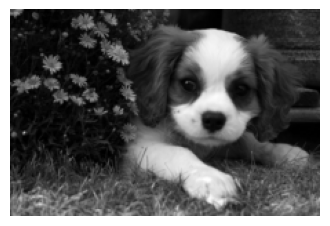

In [67]:
# Move the image tensor to the GPU
img2_gpu = img2.cuda()

# Use the loaded CUDA function
%time img_g_cuda = cuda_module.rgb_to_grayscale(img2_gpu)

# Move the result back to CPU for displaying
img_g_cuda_cpu = img_g_cuda.cpu()

show_img(img_g_cuda_cpu, cmap='gray')